In [2]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew
from scipy.stats import kurtosis
sns.set(font_scale=1.5)

In [3]:
def rms(x):
    return np.sqrt(np.mean(x**2))

In [4]:
data = pd.read_csv ("Dati_Scania_status.csv")
data.shape

(404892, 19)

In [5]:
data.columns

Index(['VIN', 'TriggerType', 'CreatedDateTime', 'ReceivedDateTime', 'Latitude',
       'Longitude', 'Heading', 'Altitude', 'Speed', 'PositionDateTime',
       'WheelBasedSpeed', 'HRTotalVehicleDistance', 'EngineTotalFuelUsed',
       'FuelLevel1', 'CatalystFuelLevel', 'DriverIdentification',
       'DriverOemIdentification', 'DriverWorkingState', 'LicensePlate'],
      dtype='object')

In [6]:
data = data.drop_duplicates().reset_index().drop(columns=['index'])
data.shape

(120269, 19)

## FEATURE ENGINEERING

In [7]:
### Aggregazione ogni 15 giorni
aggregation_step = 15

In [8]:
data = data.sort_values(by=['LicensePlate', 'CreatedDateTime'])
data['day'] = data['CreatedDateTime'].str[:10]

col_name = ['heading_mean', 'heading_min', 'heading_max', 'heading_std', 'heading_skew', 'heading_rms', 'heading_kurt',
           'altitude_mean', 'altitude_min', 'altitude_max', 'altitude_std', 'altitude_skew', 'altitude_rms', 'altitude_kurt',
           'speed_mean', 'speed_min', 'speed_max', 'speed_std', 'speed_skew', 'speed_rms', 'speed_kurt',
           'dist_mean', 'dist_min', 'dist_max', 'dist_std', 'dist_skew', 'dist_rms', 'dist_kurt',
           'fuel_mean', 'fuel_min', 'fuel_max', 'fuel_std', 'fuel_skew', 'fuel_rms', 'fuel_kurt',
           'fuel_1_mean', 'fuel_1_min', 'fuel_1_max', 'fuel_1_std', 'fuel_1_skew', 'fuel_1_rms', 'fuel_1_kurt',
           'cat_fuel_mean', 'cat_fuel_min', 'cat_fuel_max', 'cat_fuel_std', 'cat_fuel_skew', 'cat_fuel_rms', 'cat_fuel_kurt',
           'start_date', 'stop_date', 'Truck']

agg_data = []

for name in set(data['LicensePlate']):
    df_truck = data[data['LicensePlate']==name]
    days = sorted(set(df_truck['day']))
    for start, stop in zip(range(0, len(days)-aggregation_step), range(aggregation_step, len(days))):
        sublist = days[start:stop]
        df_range = df_truck[df_truck['day'].isin(sublist)]
        df_range = df_range[['Heading', 'Altitude', 'Speed', 'HRTotalVehicleDistance', 'EngineTotalFuelUsed',
                        'FuelLevel1', 'CatalystFuelLevel']]
        x=[]
        for c in df_range.columns:
            x.extend([df_range[c].mean(), df_range[c].min(), df_range[c].max(), df_range[c].std(), skew(df_range[c]), rms(df_range[c]), kurtosis(df_range[c])])
        
        x.extend([days[start], days[stop], name])
        agg_data.append(x)
        
df_tot = pd.DataFrame(agg_data, columns=col_name)
        

In [9]:
df_tot['start_date'] = pd.to_datetime(df_tot['start_date'], format='%Y-%m-%d')
df_tot['stop_date'] = pd.to_datetime(df_tot['stop_date'], format='%Y-%m-%d')

df_tot['day_distance'] = df_tot['dist_max'] - df_tot['dist_min']
df_tot['day_fuel_used'] = df_tot['fuel_max'] - df_tot['fuel_min']

df_tot = df_tot.drop(columns=['dist_min', 'dist_std', 'dist_mean', 'dist_skew', 'dist_kurt', 'dist_rms',
                              'fuel_max', 'fuel_min', 'fuel_std', 'fuel_rms', 'fuel_kurt', 'fuel_skew', 'fuel_mean'])

df_tot

,heading_mean,heading_min,heading_max,heading_std,heading_skew,heading_rms,heading_kurt,altitude_mean,altitude_min,altitude_max,...,cat_fuel_max,cat_fuel_std,cat_fuel_skew,cat_fuel_rms,cat_fuel_kurt,start_date,stop_date,Truck,day_distance,day_fuel_used
0,163.743865,2.0,359.0,91.816874,0.157044,187.695130,-0.865213,102.282209,46.0,352.0,...,100,16.329701,-0.167536,79.428760,-1.360638,2021-05-28,2021-06-15,FV904SK,779,513
1,163.380597,1.0,359.0,92.299295,0.133653,187.615735,-0.882780,101.519403,46.0,352.0,...,100,17.604668,-0.127490,76.987506,-1.249592,2021-05-29,2021-06-16,FV904SK,799,528
2,163.951952,1.0,360.0,91.848522,0.118218,187.892860,-0.858801,103.265766,46.0,352.0,...,100,19.677426,-0.140989,74.064607,-1.005632,2021-05-31,2021-06-17,FV904SK,811,529
3,163.116519,1.0,360.0,92.769706,0.129071,187.618026,-0.867715,103.436578,46.0,352.0,...,100,22.227057,-0.203318,72.531572,-0.898904,2021-06-01,2021-06-18,FV904SK,822,528
4,160.304281,1.0,360.0,92.827447,0.165777,185.205890,-0.875494,105.155963,46.0,352.0,...,100,23.757488,-0.252656,74.564915,-1.126224,2021-06-02,2021-06-19,FV904SK,806,524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,157.075495,0.0,358.0,97.770667,0.363441,184.986443,-1.014564,171.162129,107.0,428.0,...,99,25.330910,-0.420979,75.235916,-1.129961,2021-12-24,2022-01-13,FV059FV,1947,979
2017,157.584906,0.0,358.0,98.882618,0.372466,186.006654,-1.019428,174.139623,107.0,461.0,...,99,25.504026,-0.699766,78.799467,-0.838760,2021-12-27,2022-01-14,FV059FV,1887,974
2018,157.605528,0.0,358.0,99.383649,0.370966,186.290643,-1.046103,175.944724,107.0,461.0,...,99,23.207045,-0.942906,81.271445,-0.209062,2021-12-28,2022-01-15,FV059FV,1900,988
2019,157.494410,0.0,358.0,100.223750,0.375990,186.646219,-1.064666,172.464596,107.0,461.0,...,99,22.551314,-0.902966,79.963462,-0.148920,2021-12-29,2022-01-17,FV059FV,1857,977


## FEATURE SELECTION

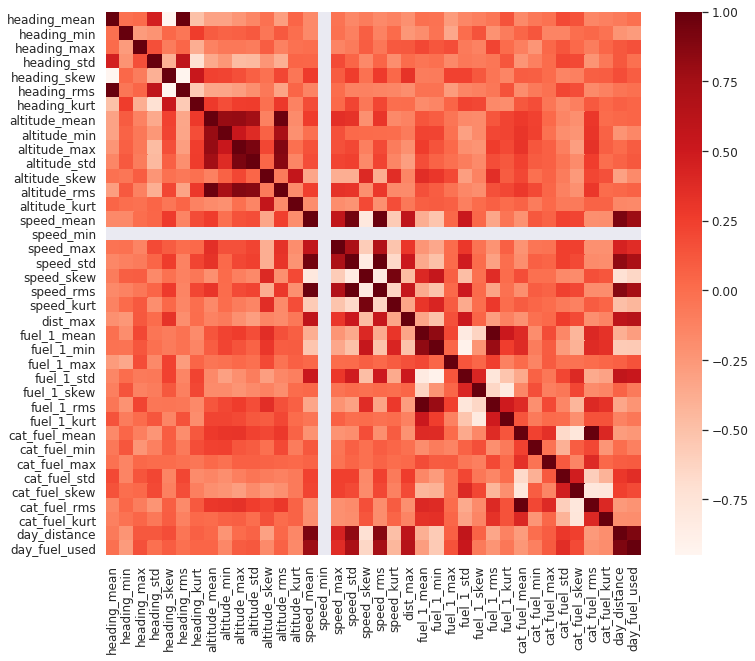

In [10]:
plt.figure(figsize=(12,10))

corr = df_tot.corr()

sns.set(font_scale=1.1)
sns.heatmap(corr, cmap=plt.cm.Reds)

In [11]:
corr = df_tot.corr()

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
selected_columns = corr.columns[columns]

df_sel = df_tot[selected_columns].copy()
df_sel['Truck'] = df_tot['Truck']
df_sel['start_date'] = df_tot['start_date']
df_sel['stop_date'] = df_tot['stop_date']
df_sel['day_distance'] = df_tot['day_distance']

selected_columns

Index(['heading_mean', 'heading_min', 'heading_max', 'heading_std',
       'heading_skew', 'heading_kurt', 'altitude_mean', 'altitude_min',
       'altitude_max', 'altitude_skew', 'altitude_kurt', 'speed_mean',
       'speed_min', 'speed_max', 'speed_skew', 'dist_max', 'fuel_1_mean',
       'fuel_1_min', 'fuel_1_max', 'fuel_1_std', 'fuel_1_skew', 'fuel_1_kurt',
       'cat_fuel_mean', 'cat_fuel_min', 'cat_fuel_max', 'cat_fuel_std',
       'cat_fuel_skew', 'cat_fuel_kurt'],
      dtype='object')

## MERGE CON FATTURE

In [12]:
df_fatture = pd.read_excel("fatture_filtered.xlsx")

# Scommentare per considerare solo un particolare gruppo di fatture 
df_fatture = df_fatture[df_fatture['Categoria componente']=='Impianto di lubrificazione motore']

df_fatture = df_fatture[['Targa', 'Data', 'label']]
df_fatture = df_fatture[df_fatture['Targa'].isin(set(df_sel['Truck']))]
len(df_fatture)

7

In [13]:
df_sel['label'] = 0
df_sel = df_sel[df_sel['Truck'].isin(set(df_fatture['Targa']))]
df_sel = df_sel.reset_index(drop=True)

def nearest(items, pivot):
    items_min = [y for y in items if y<=pivot]
    if len(items_min)>0:
        time = min(items_min, key=lambda x: pivot-x)
        return pd.to_datetime(time, format='%Y-%m-%d')
    else: 
        return -1

In [14]:
from datetime import datetime, timedelta

df_fatture = df_fatture.reset_index(drop=True)
for i in range(df_fatture.shape[0]):
    t = df_fatture['Targa'][i]
    d = df_fatture['Data'][i]
    
    df_truck = df_sel[df_sel['Truck'] == t]
    min_ind = nearest(df_truck['stop_date'], d)
    if(min_ind!=-1):
        df_sel.loc[(df_sel['Truck']==t) & (df_sel['stop_date'] == min_ind), 'label'] = 1
        #for i in range(1, h):
        #    df_sel.loc[(df_sel['Truck']==t) & (df_sel['day'] == min_ind-timedelta(days=i)), 'label'] = 1
    
df_sel['label'].value_counts()

0    613
1      5
Name: label, dtype: int64

In [15]:
df_sel['RUL'] = -1
df_damage = df_sel[df_sel['label']==1].copy()
df_damage=df_damage.reset_index(drop=True)

for i in range(df_damage.shape[0]):
    truck = df_damage['Truck'][i]
    day = df_damage['stop_date'][i]
    tot_km = df_damage['dist_max'][i]
    df_truck = df_sel[(df_sel['Truck']==truck) & (df_sel['stop_date'] <= day)]
    df_sel.loc[(df_sel['Truck']==truck) & (df_sel['stop_date'] <= day) & (df_sel['RUL']==-1), 'RUL'] = tot_km - df_sel['dist_max']    

In [16]:
df_sel=df_sel[df_sel['RUL']!=-1]
df_sel

,heading_mean,heading_min,heading_max,heading_std,heading_skew,heading_kurt,altitude_mean,altitude_min,altitude_max,altitude_skew,...,cat_fuel_max,cat_fuel_std,cat_fuel_skew,cat_fuel_kurt,Truck,start_date,stop_date,day_distance,label,RUL
0,178.878476,1.0,360.0,102.539807,-0.007185,-1.167522,46.995881,33.0,89.0,1.225321,...,100,18.784179,0.023801,-0.540735,FV913SK,2021-05-28,2021-06-16,1269,0,7088
1,177.818455,1.0,360.0,103.098026,0.009751,-1.188520,47.059178,33.0,89.0,1.248969,...,100,17.968960,0.158811,-0.455673,FV913SK,2021-05-29,2021-06-17,1265,0,6999
2,179.833171,1.0,360.0,102.941657,-0.019908,-1.185525,47.131707,33.0,89.0,1.330724,...,100,17.697558,0.120832,-0.513902,FV913SK,2021-05-31,2021-06-18,1287,0,6892
3,179.177388,1.0,360.0,103.580833,-0.007871,-1.208548,47.152047,33.0,89.0,1.284595,...,92,17.556211,-0.240772,-0.584407,FV913SK,2021-06-01,2021-06-19,1322,0,6782
4,180.888666,1.0,360.0,103.436944,-0.013312,-1.196547,47.078235,33.0,89.0,1.303250,...,100,17.988205,-0.050578,-0.189503,FV913SK,2021-06-02,2021-06-21,1339,0,6694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,195.364991,5.0,360.0,109.659586,-0.142515,-1.402717,49.486034,10.0,105.0,-0.145841,...,100,17.306041,-0.350061,-1.240834,FV907SK,2021-06-09,2021-07-13,1023,0,97
496,195.211765,5.0,360.0,109.385667,-0.129252,-1.393529,49.854902,10.0,105.0,-0.072340,...,100,17.737353,-0.182156,-1.294524,FV907SK,2021-06-10,2021-07-14,935,0,90
497,197.588235,5.0,360.0,110.049761,-0.168120,-1.397035,50.347059,10.0,105.0,0.138774,...,100,17.850087,-0.152839,-1.305593,FV907SK,2021-06-11,2021-07-15,935,0,90
498,197.942197,5.0,360.0,108.995893,-0.183056,-1.364379,50.631985,10.0,105.0,0.431328,...,100,18.155926,-0.106205,-1.335933,FV907SK,2021-06-29,2021-07-17,959,0,66


In [17]:
df_damage

,heading_mean,heading_min,heading_max,heading_std,heading_skew,heading_kurt,altitude_mean,altitude_min,altitude_max,altitude_skew,...,cat_fuel_max,cat_fuel_std,cat_fuel_skew,cat_fuel_kurt,Truck,start_date,stop_date,day_distance,label,RUL
0,191.966628,2.0,359.0,106.720143,-0.180958,-1.308669,47.318757,31.0,112.0,1.574526,...,100,18.931944,-0.086323,-0.941182,FV913SK,2021-09-03,2021-09-24,1328,1,-1
1,192.155804,0.0,359.0,109.582365,-0.202830,-1.294460,50.717923,34.0,428.0,13.897085,...,100,16.623951,-0.511244,-0.720176,FZ330SC,2021-06-09,2021-06-30,1658,1,-1
2,200.750842,0.0,359.0,104.197687,-0.430685,-1.100372,49.184063,33.0,85.0,1.258571,...,100,14.722365,-0.876321,1.154071,FZ330SC,2021-08-04,2021-08-27,1339,1,-1
3,163.693252,0.0,358.0,103.997551,0.288519,-1.102992,212.963190,1.0,958.0,1.505356,...,100,16.304367,-1.011263,-0.086895,FV914SK,2021-11-26,2021-12-15,1579,1,-1
4,198.891013,5.0,360.0,109.185971,-0.200165,-1.346179,53.043977,34.0,109.0,1.550417,...,100,18.371454,0.075213,-1.338583,FV907SK,2021-06-30,2021-07-19,957,1,-1


### PREDICTIVE MODEL

In [18]:
df_exp = df_sel.drop(columns=['Truck', 'stop_date', 'start_date', 'label'])
df_exp

,heading_mean,heading_min,heading_max,heading_std,heading_skew,heading_kurt,altitude_mean,altitude_min,altitude_max,altitude_skew,...,fuel_1_skew,fuel_1_kurt,cat_fuel_mean,cat_fuel_min,cat_fuel_max,cat_fuel_std,cat_fuel_skew,cat_fuel_kurt,day_distance,RUL
0,178.878476,1.0,360.0,102.539807,-0.007185,-1.167522,46.995881,33.0,89.0,1.225321,...,0.007459,-1.031258,68.815654,0,100,18.784179,0.023801,-0.540735,1269,7088
1,177.818455,1.0,360.0,103.098026,0.009751,-1.188520,47.059178,33.0,89.0,1.248969,...,-0.064442,-1.155029,66.000000,0,100,17.968960,0.158811,-0.455673,1265,6999
2,179.833171,1.0,360.0,102.941657,-0.019908,-1.185525,47.131707,33.0,89.0,1.330724,...,-0.125756,-1.058597,62.412683,0,100,17.697558,0.120832,-0.513902,1287,6892
3,179.177388,1.0,360.0,103.580833,-0.007871,-1.208548,47.152047,33.0,89.0,1.284595,...,-0.074339,-1.106406,57.946394,0,92,17.556211,-0.240772,-0.584407,1322,6782
4,180.888666,1.0,360.0,103.436944,-0.013312,-1.196547,47.078235,33.0,89.0,1.303250,...,-0.031242,-1.098012,57.436309,0,100,17.988205,-0.050578,-0.189503,1339,6694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,195.364991,5.0,360.0,109.659586,-0.142515,-1.402717,49.486034,10.0,105.0,-0.145841,...,-0.263305,-0.741681,80.739292,48,100,17.306041,-0.350061,-1.240834,1023,97
496,195.211765,5.0,360.0,109.385667,-0.129252,-1.393529,49.854902,10.0,105.0,-0.072340,...,-0.476006,-0.271227,77.578431,48,100,17.737353,-0.182156,-1.294524,935,90
497,197.588235,5.0,360.0,110.049761,-0.168120,-1.397035,50.347059,10.0,105.0,0.138774,...,-0.478078,-0.160759,76.966667,48,100,17.850087,-0.152839,-1.305593,935,90
498,197.942197,5.0,360.0,108.995893,-0.183056,-1.364379,50.631985,10.0,105.0,0.431328,...,-0.449713,-0.059551,75.963391,48,100,18.155926,-0.106205,-1.335933,959,66


In [19]:
Y = df_exp['RUL'].copy()
X = df_exp.drop(columns=['RUL'])

In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
import warnings
warnings.filterwarnings('ignore')

model = XGBRegressor()
loo = LeaveOneOut()
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error',
                         cv=50, n_jobs=-1)

print("Maximum real RUL: ", df_exp['RUL'].max())
print("Mean real RUL: ", df_exp['RUL'].mean())

print("Mean absolute error: ", mean(absolute(scores)))

Maximum real RUL:  18513
Mean real RUL:  6076.8
Mean absolute error:  468.77858941804794


### Prediction with only one trucks ###

In [21]:
truck = 'FZ330SC'

df_truck = df_sel[df_sel['Truck']== truck]
df_truck = df_truck.drop(columns=['Truck', 'stop_date', 'start_date', 'label'])

In [22]:
Y = df_truck['RUL'].copy()
X = df_truck.drop(columns=['RUL'])

In [23]:
model = XGBRegressor(verbosity=0)
loo = LeaveOneOut()
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error',
                         cv=loo, n_jobs=-1)

y_pred = cross_val_predict(model, X, Y,
                         cv=loo)

print("Maximum real RUL: ", Y.max())
print("Mean real RUL: ", Y.mean())

print("Mean absolute error: ", mean(absolute(scores)))

Maximum real RUL:  3738
Mean real RUL:  1587.7735849056603
Mean absolute error:  232.4960494131412


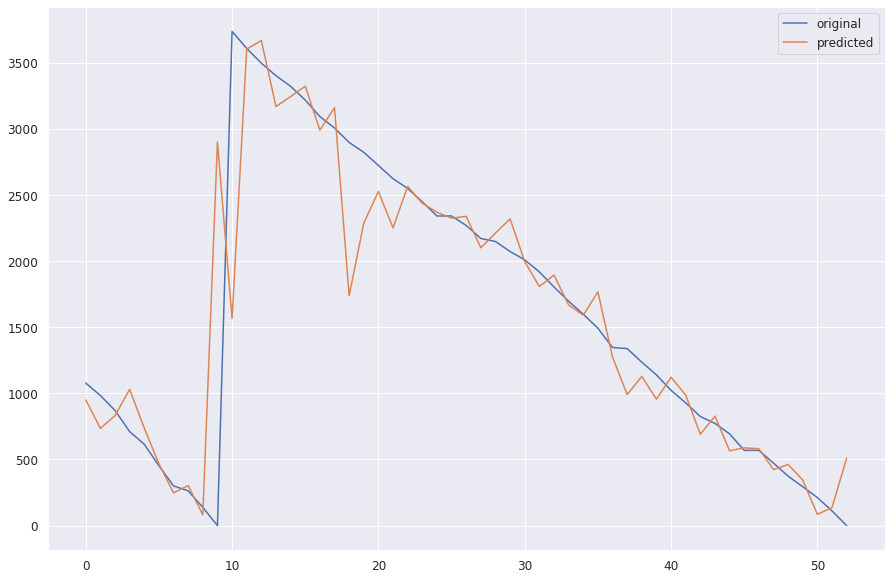

In [24]:
plt.figure(figsize=(15,10))
plt.plot(range(len(Y)), Y, label='original')
plt.plot(range(len(y_pred)), y_pred, label='predicted')
plt.legend()
plt.show()

### One truck for training and others for test

In [45]:
df_train = df_sel[df_sel['Truck'].isin(['FV907SK', 'FV913SK', 'FV914SK'])]
df_train = df_train.drop(columns=['Truck', 'stop_date', 'label', 'start_date'])

In [46]:
df_test = df_sel[df_sel['Truck'].isin(['FZ330SC'])]
df_test = df_test.drop(columns=['Truck', 'stop_date', 'label', 'start_date'])

In [47]:
Y_train = df_train['RUL'].copy()
X_train = df_train.drop(columns=['RUL'])

Y_test = df_test['RUL'].copy()
X_test = df_test.drop(columns=['RUL'])

In [48]:
from sklearn.metrics import mean_absolute_error
model = XGBRegressor()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

print("Maximum real RUL: ", Y_test.max())
print("Mean real RUL: ", Y_test.mean())

print("Mean absolute error: ", mean_absolute_error(y_pred, Y_test))

[06:32:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Maximum real RUL:  3738
Mean real RUL:  1587.7735849056603
Mean absolute error:  1063.2984757333431


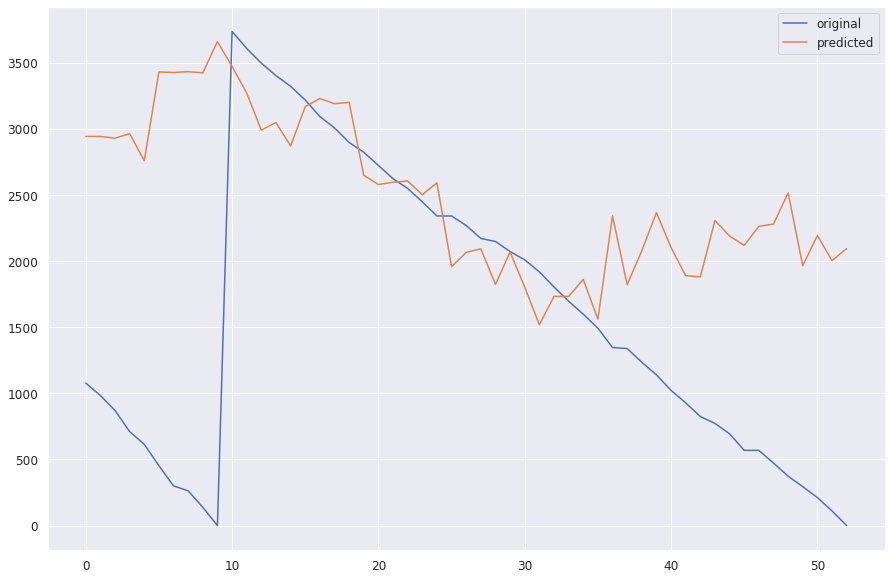

In [49]:
plt.figure(figsize=(15,10))
plt.plot(range(len(Y_test)), Y_test, label='original')
plt.plot(range(len(y_pred)), y_pred, label='predicted')
plt.legend()
plt.show()